In [1]:
from ramandecompy import spectrafit
from ramandecompy import dataprep
import h5py
import matplotlib.pyplot as plt

In [2]:
hdf5_file = 'ramandecompy/tests/test_files/dataprep_experiment.hdf5'
key = '300C/25s'
hdf5 = h5py.File(hdf5_file, 'r')
x_data = list(hdf5['{}/{}'.format(key, 'wavenumber')])
y_data = list(hdf5['{}/{}'.format(key, 'counts')])

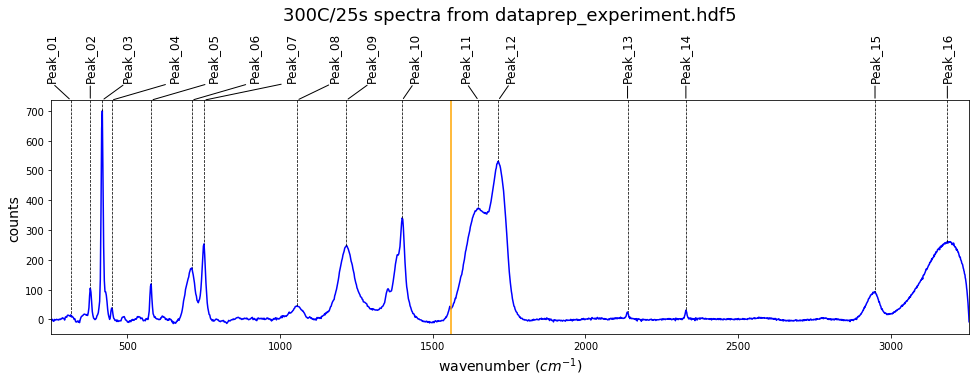

In [3]:
fig, ax = dataprep.plot_fit(hdf5_file, key)
plt.axvline(x=1560, color='orange')

develop a new function that will refit the data using the original fit plus a dictionary of custom locations. The dictionary elements with either be integer wavenumbers, or string Peak_#s, followed by how many peaks should be applied to that location.

In [4]:
# extract peak center and height locations from hdf5
peaks = []
for _,peak in enumerate(list(hdf5[key])[:-2]):
    peaks.append((list(hdf5['{}/{}'.format(key, peak)])[2], list(hdf5['{}/{}'.format(key, peak)])[5]))
peaks

[(314.77, 14.96795),
 (378.71, 104.63),
 (418.14, 700.0),
 (448.67, 38.0575),
 (578.11, 118.9575),
 (711.51, 172.735),
 (751.21, 253.375),
 (1055.9, 45.846000000000004),
 (1217.6, 247.8775),
 (1400.1, 340.66),
 (1649.3, 373.78),
 (1714.9, 530.63),
 (2137.9, 24.81825),
 (2328.9, 30.69175),
 (2948.2, 93.00025),
 (3185.1, 260.8875)]

In [5]:
from scipy import interpolate
# specify a peaks to add manually
peak_loc = [1350, 1385]
# interpolate data
comp_int = interpolate.interp1d(x_data, y_data, kind='cubic')
# iterate through peak_loc
peaks_add = []
for _,guess in enumerate(peak_loc):
    height = comp_int(int(guess))
    peaks_add.append((int(guess), int(height)))
peaks_add

[(1350, 94), (1385, 217)]

In [6]:
from lmfit.models import PseudoVoigtModel

mod, pars = spectrafit.set_params(peaks)
peak_list = []
for i, _ in enumerate(peaks_add):
    prefix = 'p{}_'.format(i+1+len(peaks))
    peak = PseudoVoigtModel(prefix=prefix)
    pars.update(peak.make_params())
    pars[prefix+'center'].set(peaks_add[i][0], vary=True, min=(peaks_add[i][0]-10), max=(peaks_add[i][0]+10))
#     pars[prefix+'height'].set(peaks_add[i][1], vary=True)
    pars[prefix+'height'].set(min=0.1*peaks_add[i][1])
    pars[prefix+'sigma'].set(100, min=1, max=150)
    pars[prefix+'amplitude'].set(min=0)
    peak_list.append(peak)
    mod = mod + peak_list[i]

In [7]:
out = spectrafit.model_fit(x_data, y_data, mod, pars, report=True)

[[Model]]
    (((((((((((((((((Model(pvoigt, prefix='p1_') + Model(pvoigt, prefix='p2_')) + Model(pvoigt, prefix='p3_')) + Model(pvoigt, prefix='p4_')) + Model(pvoigt, prefix='p5_')) + Model(pvoigt, prefix='p6_')) + Model(pvoigt, prefix='p7_')) + Model(pvoigt, prefix='p8_')) + Model(pvoigt, prefix='p9_')) + Model(pvoigt, prefix='p10_')) + Model(pvoigt, prefix='p11_')) + Model(pvoigt, prefix='p12_')) + Model(pvoigt, prefix='p13_')) + Model(pvoigt, prefix='p14_')) + Model(pvoigt, prefix='p15_')) + Model(pvoigt, prefix='p16_')) + Model(pvoigt, prefix='p17_')) + Model(pvoigt, prefix='p18_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25562
    # data points      = 1941
    # variables        = 56
    chi-square         = 333788.464
    reduced chi-square = 177.076108
    Akaike info crit   = 10102.9173
    Bayesian info crit = 10414.8910
[[Variables]]
    p1_fraction:    8.3267e-16 (init = 0.5)
    p1_sigma:       8.95810394 (init = 100)
    p1_center:    

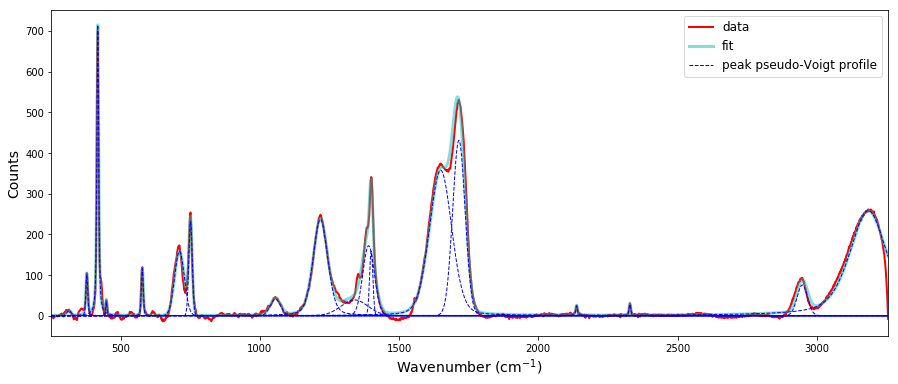

In [8]:
import numpy as np
x_data = np.asarray(x_data)
y_data = np.asarray(y_data)

spectrafit.plot_fit(x_data, y_data, out, plot_components=True)

now to explore a bit with loosening the sensitivity of the automatic functions to detect too many peaks and then remove those with too small of an area to contribute

In [11]:
# peaks = spectrafit.peak_detect(x_data, y_data, height=(0.02*max(y_data)), prominence=(0.01*max(y_data)))[0]
# len(peaks)
# extract peak center and height locations from hdf5
peaks = []
for _,peak in enumerate(list(hdf5[key])[:-2]):
    peaks.append((list(hdf5['{}/{}'.format(key, peak)])[2], list(hdf5['{}/{}'.format(key, peak)])[5]))
peaks

[(314.77, 14.96795),
 (378.71, 104.63),
 (418.14, 700.0),
 (448.67, 38.0575),
 (578.11, 118.9575),
 (711.51, 172.735),
 (751.21, 253.375),
 (1055.9, 45.846000000000004),
 (1217.6, 247.8775),
 (1400.1, 340.66),
 (1649.3, 373.78),
 (1714.9, 530.63),
 (2137.9, 24.81825),
 (2328.9, 30.69175),
 (2948.2, 93.00025),
 (3185.1, 260.8875)]

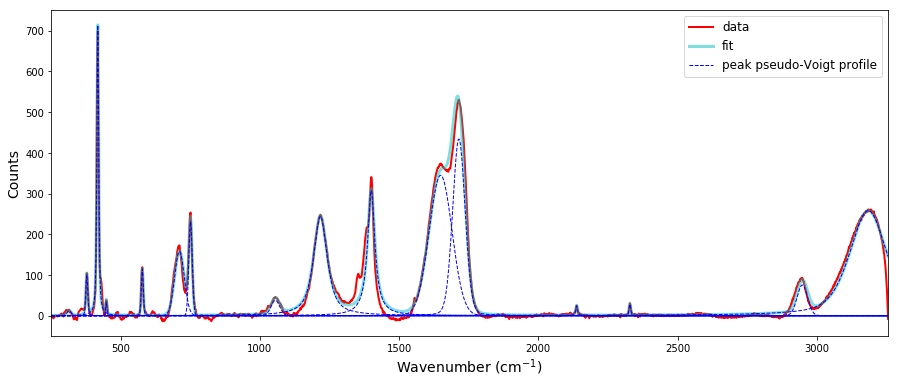

In [12]:
mod, pars = spectrafit.set_params(peaks)
out = spectrafit.model_fit(x_data, y_data, mod, pars)
spectrafit.plot_fit(x_data, y_data, out, plot_components=True)